In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import trange
import networkx as nx

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.linear_model._logistic")

In [2]:
best_refs = pd.read_csv('scaffold_references.csv')
best_refs['Scaffold assembly'] = best_refs['Query assembly'] + '_scaffold'

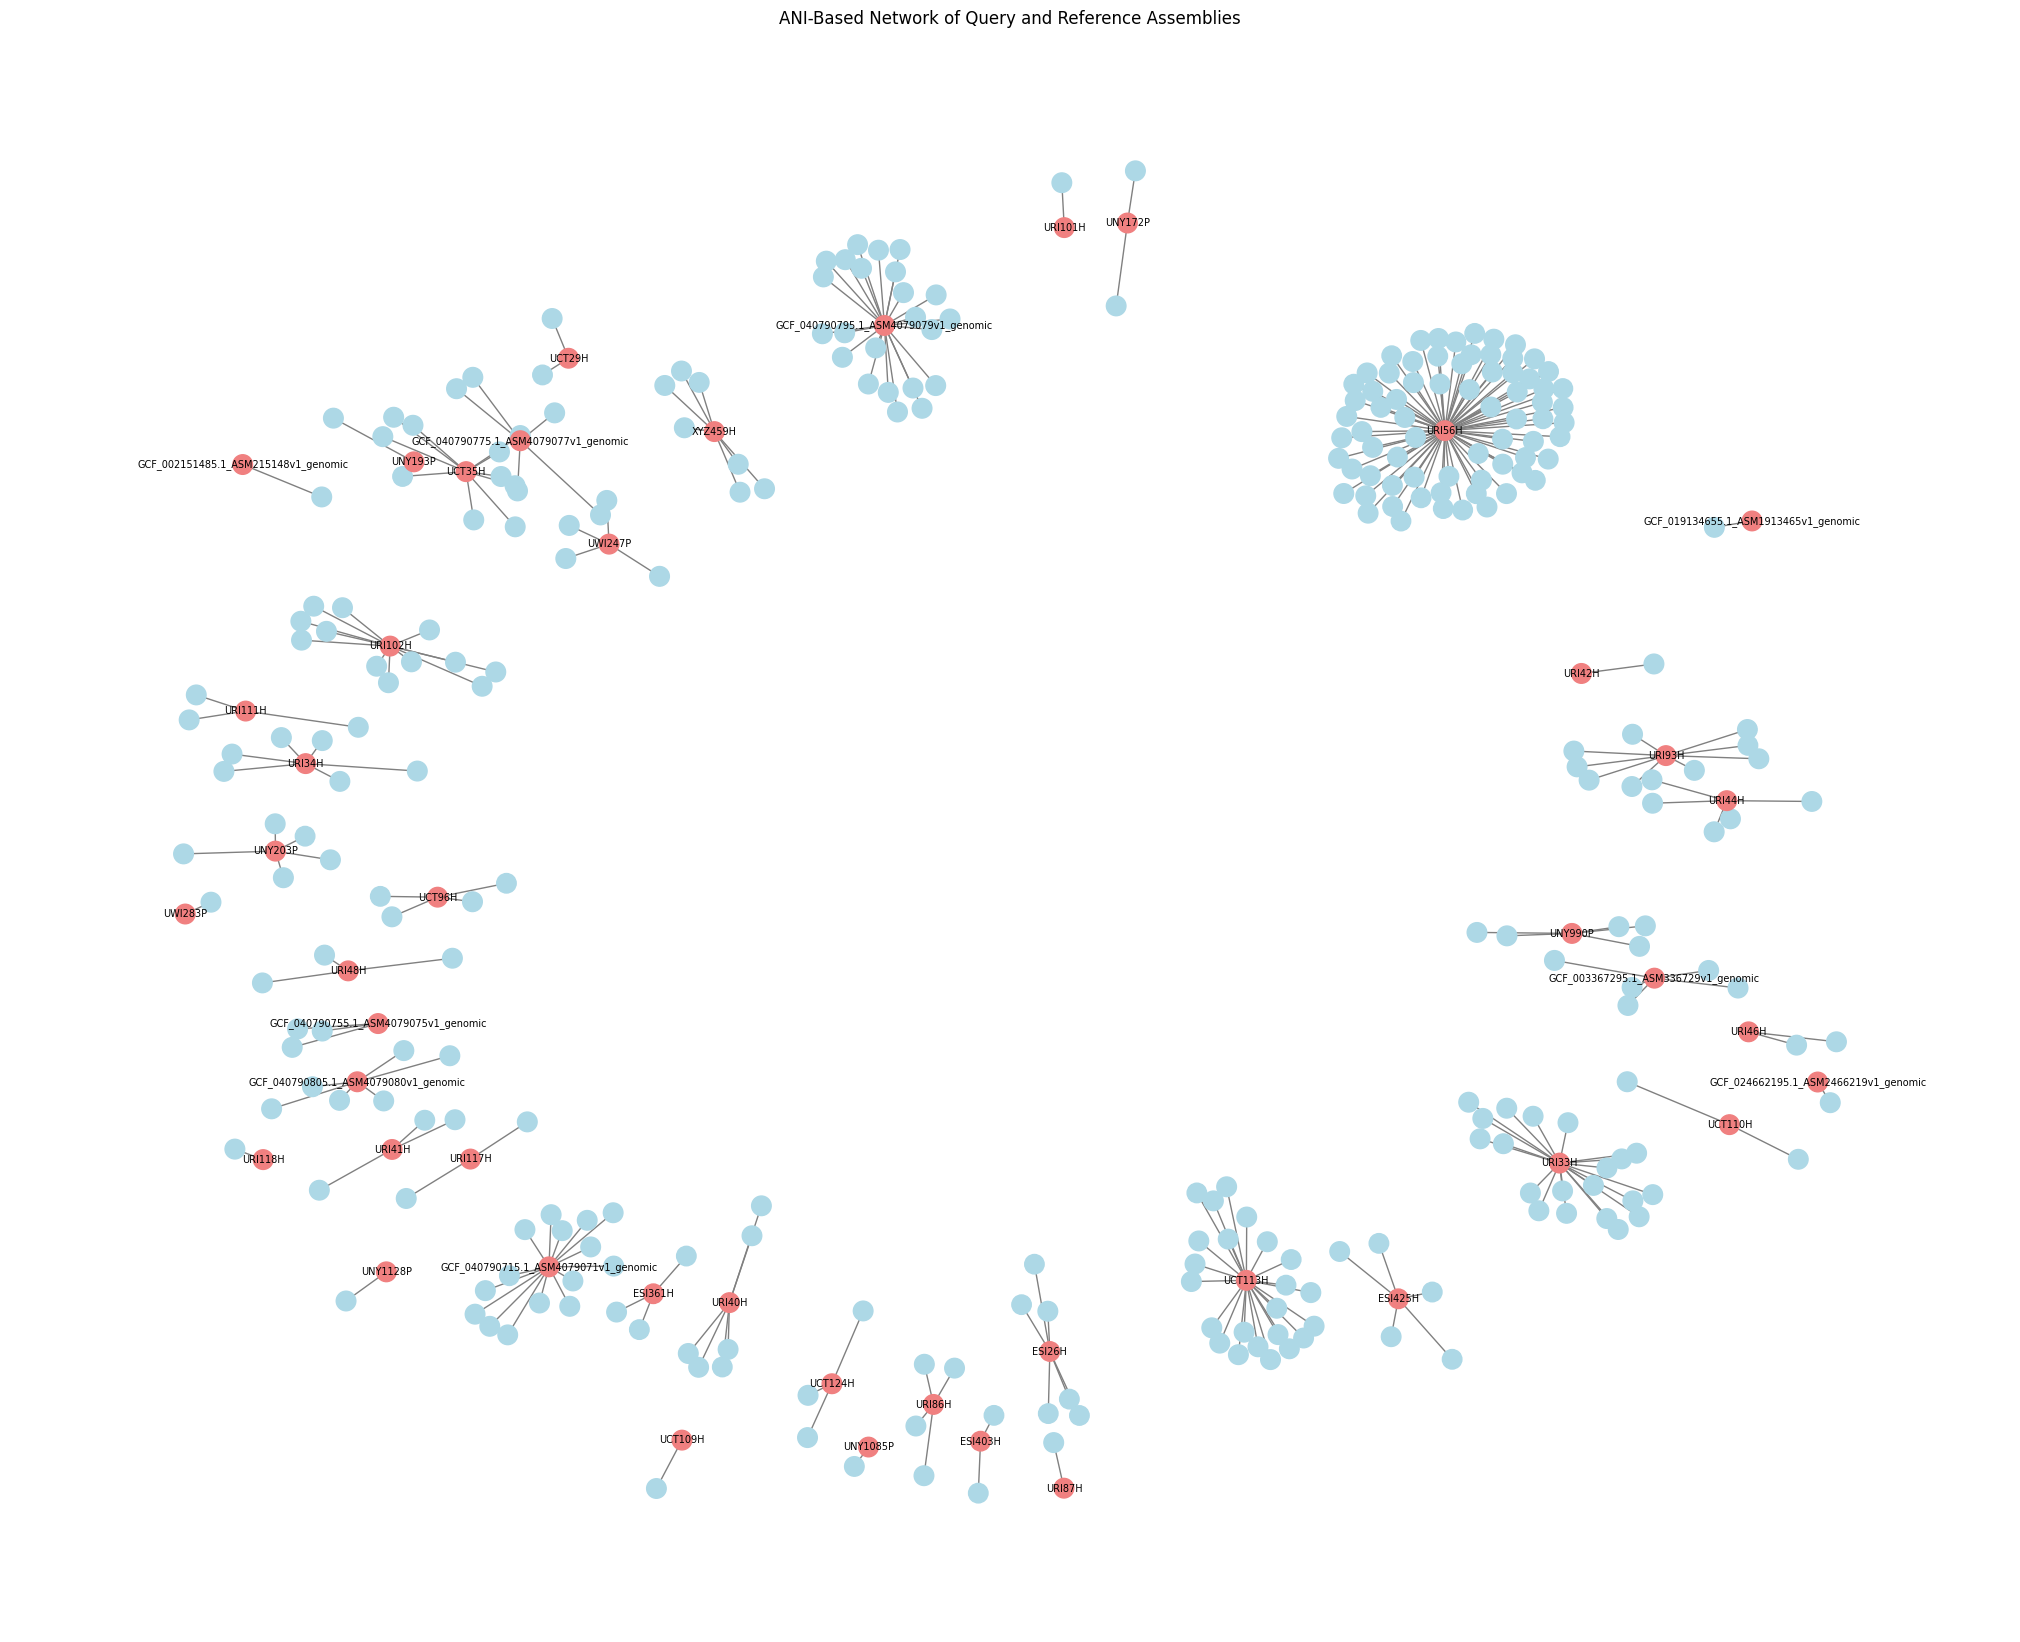

In [3]:
##### PANEL A
# Create a graph
G = nx.Graph()

# Add Query nodes with ANI-based sizes
query_sizes = {row['Query assembly']: row['ANI (mean)'] for _, row in best_refs.iterrows()}
for node, size in query_sizes.items():
    G.add_node(node, size=size, color='lightblue')

# Compute mean ANI for Ref assemblies
ref_sizes = best_refs.groupby('Ref assembly')['ANI (mean)'].mean().to_dict()
for node, size in ref_sizes.items():
    G.add_node(node, size=size, color='lightcoral')

# Add edges between Query and Ref assemblies
for _, row in best_refs.iterrows():
    G.add_edge(row['Query assembly'], row['Ref assembly'])

# Adjust node size scaling (decrease slightly)
node_sizes = [G.nodes[n]['size'] * 2 for n in G.nodes]  # Reduce scaling factor
node_colors = [G.nodes[n]['color'] for n in G.nodes]

# Increase spacing with spring layout
pos = nx.spring_layout(G, seed=2, k=0.1)  # Increase k to spread nodes out

# Draw network
plt.figure(figsize=(20, 16))  # Increase figure size
nx.draw(G, pos, with_labels=False, node_size=node_sizes, node_color=node_colors, edge_color='gray', font_size=7)

# Label refs
labels = {n: n for n in G.nodes if G.nodes[n]['color'] == 'lightcoral'}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=7)

plt.title("ANI-Based Network of Query and Reference Assemblies")
plt.show()

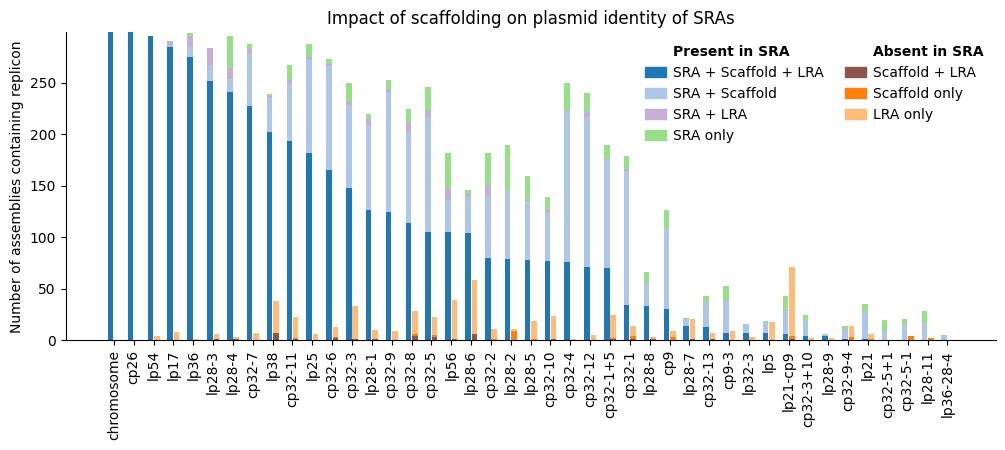

In [4]:
##### PANEL B
sra_calls = pd.read_csv('SRAs/replicon_annotations_1000bp.csv')
sra_calls_all = pd.read_csv('SRAs/replicon_annotations.csv')
scaf_calls = pd.read_csv('scaffolded_asms/replicon_annotations_1000bp.csv')
scaf_calls_all = pd.read_csv('scaffolded_asms/replicon_annotations.csv')
lra_calls = pd.read_csv('LRAs/replicon_annotations_1000bp.csv')
lra_calls_all = pd.read_csv('LRAs/replicon_annotations.csv')

sra_replicons = sra_calls[['assembly_id', 'plasmid_name']].groupby('assembly_id').agg(lambda x: sorted(list(set(list(x))))).reset_index()
scaf_replicons = scaf_calls[['assembly_id', 'plasmid_name']].groupby('assembly_id').agg(lambda x: sorted(list(set(list(x))))).reset_index()
lra_replicons = lra_calls[['assembly_id', 'plasmid_name']].groupby('assembly_id').agg(lambda x: sorted(list(set(list(x))))).reset_index()

replicon_matches = \
    pd.merge(
        pd.merge(
            pd.merge(best_refs, lra_replicons, left_on='Ref assembly', right_on='assembly_id', how='outer').rename(columns={'plasmid_name':'LRA replicons', 'assembly_id':'LRA assembly'}),
            sra_replicons, left_on='Query assembly', right_on='assembly_id', how='outer').rename(columns={'plasmid_name':'SRA replicons', 'assembly_id':'SRA assembly'}),
        scaf_replicons, left_on='Scaffold assembly', right_on='assembly_id', how='outer').rename(columns={'plasmid_name':'Scaffold replicons'}).drop(columns='assembly_id')
replicon_matches = replicon_matches[['SRA assembly', 'Scaffold assembly', 'LRA assembly', 'ANI (mean)', 'SRA replicons', 'Scaffold replicons', 'LRA replicons']]
replicon_matches = replicon_matches.dropna().reset_index(drop=True)
replicon_matches

all_reps = pd.DataFrame(pd.concat([sra_calls['plasmid_name'], scaf_calls['plasmid_name'], lra_calls['plasmid_name']])).drop_duplicates().reset_index(drop=True)
all_reps = all_reps.rename(columns={'plasmid_name':'replicon'})
all_reps['Count (SRA, Scaf, LRA)'] = 0
all_reps['Count (SRA, Scaf)'] = 0
all_reps['Count (SRA, LRA)'] = 0
all_reps['Count (Scaf, LRA)'] = 0
all_reps['Count (SRA)'] = 0
all_reps['Count (Scaf)'] = 0
all_reps['Count (LRA)'] = 0
for i, row in all_reps.iterrows():
    replicon = row['replicon']
    sra_idxs = replicon_matches[replicon_matches['SRA replicons'].apply(lambda x: replicon in x)].index.tolist()
    scaf_idxs = replicon_matches[replicon_matches['Scaffold replicons'].apply(lambda x: replicon in x)].index.tolist()
    lra_idxs = replicon_matches[replicon_matches['LRA replicons'].apply(lambda x: replicon in x)].index.tolist()

    col_idx = all_reps.columns.tolist().index('Count (SRA, Scaf, LRA)')
    all_reps.iloc[i, col_idx] += len(set(sra_idxs).intersection(set(scaf_idxs)).intersection(set(lra_idxs)))

    col_idx = all_reps.columns.tolist().index('Count (SRA, Scaf)')
    all_reps.iloc[i, col_idx] += len(set(sra_idxs).intersection(set(scaf_idxs)) - set(lra_idxs))

    col_idx = all_reps.columns.tolist().index('Count (SRA, LRA)')
    all_reps.iloc[i, col_idx] += len(set(sra_idxs).intersection(set(lra_idxs)) - set(scaf_idxs))

    col_idx = all_reps.columns.tolist().index('Count (Scaf, LRA)')
    all_reps.iloc[i, col_idx] += len(set(scaf_idxs).intersection(set(lra_idxs)) - set(sra_idxs))

    col_idx = all_reps.columns.tolist().index('Count (SRA)')
    all_reps.iloc[i, col_idx] += len(set(sra_idxs) - set(scaf_idxs).union(set(lra_idxs)))

    col_idx = all_reps.columns.tolist().index('Count (Scaf)')
    all_reps.iloc[i, col_idx] += len(set(scaf_idxs) - set(sra_idxs).union(set(lra_idxs)))

    col_idx = all_reps.columns.tolist().index('Count (LRA)')
    all_reps.iloc[i, col_idx] += len(set(lra_idxs) - set(sra_idxs).union(set(scaf_idxs)))
    
def plot_minibars(ax, replicon, colors, width=0.8):
    x_pos = all_reps[all_reps['replicon'] == replicon].index[0]
    scale_factor = 0.1
    bar_width = (scale_factor * (width - 1) + width) / 2
    x_left = x_pos - width / 2 + bar_width / 2
    x_right = x_pos + width / 2 - bar_width / 2

    # Now based on SRA presence
    left_columns = ['Count (SRA, Scaf, LRA)', 'Count (SRA, Scaf)', 'Count (SRA, LRA)', 'Count (SRA)']
    right_columns = ['Count (Scaf, LRA)', 'Count (Scaf)', 'Count (LRA)']

    row = all_reps[all_reps['replicon'] == replicon].iloc[0]

    bottom = 0
    for i, col in enumerate(left_columns):
        height = row[col]
        ax.bar(x_left, height, width=bar_width, bottom=bottom, color=colors[0][i])
        bottom += height

    bottom = 0
    for i, col in enumerate(right_columns):
        height = row[col]
        ax.bar(x_right, height, width=bar_width, bottom=bottom, color=colors[1][i])
        bottom += height


def draw_legend(ax, colors, fs=10):
    left_labels = ['SRA + Scaffold + LRA', 'SRA + Scaffold', 'SRA + LRA', 'SRA only']
    right_labels = ['Scaffold + LRA', 'Scaffold only', 'LRA only']

    left_colors = colors[0]
    right_colors = colors[1]

    left_patches = [mpatches.Patch(color=c, label=l) for c, l in zip(left_colors, left_labels)]
    right_patches = [mpatches.Patch(color=c, label=l) for c, l in zip(right_colors, right_labels)]

    header_left = mpatches.Patch(color='none', label='Present in SRA')
    header_right = mpatches.Patch(color='none', label='Absent in SRA')
    legend_patches = [header_left] + left_patches + [header_right] + right_patches

    legend = ax.legend(
        handles=legend_patches,
        ncol=2,
        loc='upper right',
        frameon=False,
        handlelength=1.5,
        handletextpad=0.5,
        columnspacing=1.5,
        fontsize=fs
    )
    legend.get_texts()[0].set_weight('bold')
    legend.get_texts()[5].set_weight('bold')


# Sorting still optional; use whatever order you'd like
all_reps = all_reps.sort_values(by=['Count (SRA, Scaf, LRA)', 'replicon'], ascending=[False, True]).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(12, 4))

colors = [
    ['#1f77b4', '#aec7e8', '#c5b0d5', '#98df8a'],  # SRA-present
    ['#8c564b', '#ff7f0e', '#ffbb78']              # SRA-absent (brown and tan)
]

for replicon in all_reps['replicon']:
    plot_minibars(ax, replicon, colors, width=0.6)

draw_legend(ax, colors)

ax.set_xticks(range(len(all_reps)))
ax.set_xticklabels(all_reps['replicon'], rotation=90)
ax.set_ylabel("Count")
ax.spines[['top', 'right']].set_visible(False)

ax.set_title("Impact of scaffolding on plasmid identity of SRAs")
ax.set_ylabel('Number of assemblies containing replicon');

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:12<00:00, 15.70it/s]


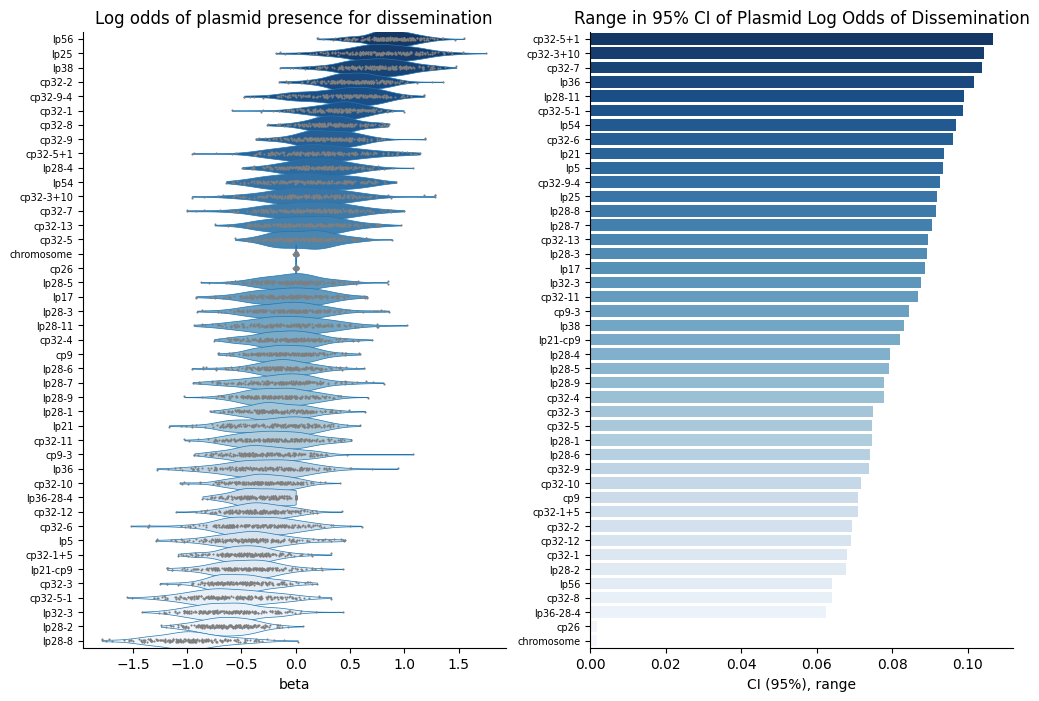

In [5]:
##### PANEL C
scaf_calls = pd.read_csv('scaffolded_asms/replicon_annotations_1000bp.csv')
scaf_calls['Isolate'] = scaf_calls['assembly_id'].apply(lambda x: x.split('_scaffold')[0])
scaf_calls['Present'] = 1
scaf_features = scaf_calls[['Isolate', 'plasmid_name', 'Present']].drop_duplicates().pivot(index='Isolate', columns='plasmid_name', values='Present').reset_index()
scaf_features = scaf_features.fillna(0)
plasmid_list = sorted(list(scaf_calls['plasmid_name'].unique()))
dissemination = pd.read_csv('LymeSeq_SampleTrack - Renaming Scheme Table for Jupyter.2023-02-14.csv')
regression_df = pd.merge(
    scaf_features,
    dissemination[['Rename_A', 'Disseminated']],
    left_on='Isolate',
    right_on='Rename_A')
regression_df = regression_df[['Isolate', 'Disseminated']+plasmid_list]
regression_df['Disseminated binary'] = regression_df['Disseminated'].apply(lambda x: {'L':0, 'D':1, 'ND':None}[x])
regression_df = regression_df.dropna().reset_index(drop=True)

def fit_model(X, Y):
    penalty='l2'
    solver='lbfgs'
    max_iter=1000
    class_weight='balanced'
    clf = LogisticRegression(penalty=penalty,
                             solver=solver,
                             max_iter=max_iter,
                             class_weight=class_weight)
    clf.fit(X, Y)
    y_pred = clf.predict(X)
    y_prob = clf.predict_proba(X)[:, 1]

    betas = clf.coef_.flatten()
    cm = confusion_matrix(Y, (y_pred > 0.5).astype(int))
    metrics = {
        'accuracy': accuracy_score(Y, y_pred),
        'precision': precision_score(Y, y_pred),
        'recall': recall_score(Y, y_pred),
        'f1': f1_score(Y, y_pred),
        'auc': roc_auc_score(Y, y_prob)
    }

    return metrics, cm, betas, clf

bootstrap_iter = 200
subsample_n = 80
metrics_all = defaultdict(list)
betas_all = []
odds_ratios_all = []
cm_all = []
models_all = []
for _ in trange(bootstrap_iter):
    random_state = np.random.randint(10*bootstrap_iter)
    subsample = regression_df.groupby('Disseminated').sample(subsample_n, replace=False, random_state=random_state)
    X = subsample[plasmid_list]
    Y = subsample['Disseminated binary']
    metrics, cm, betas, model = fit_model(X, Y)
    for k, v in metrics.items():
        metrics_all[k].append(v)
    betas_all.append(betas)
    cm_all.append(cm)
    models_all.append(model)
cm_all = np.stack(cm_all)
betas_all = np.stack(betas_all)

def compute_ci(beta_list, confidence=0.95):
    arr = np.array(beta_list)
    n = len(arr)
    mean = np.mean(arr)
    sem = stats.sem(arr)  # Standard error of the mean
    h = sem * stats.t.ppf((1 + confidence) / 2., n-1)  # Margin of error
    return [mean - h, mean + h]

beta_df = pd.DataFrame({'plasmid':plasmid_list, 'mean beta':betas_all.mean(axis=0), 'beta':[arr for arr in betas_all.transpose(1, 0)]}).sort_values(by='mean beta', ascending=False).reset_index(drop=True)
beta_df['CI (95%), lower'] = beta_df['beta'].apply(lambda x: compute_ci(x)[0])
beta_df['CI (95%), upper'] = beta_df['beta'].apply(lambda x: compute_ci(x)[1])
beta_df['CI (95%), range'] = beta_df['CI (95%), upper'] - beta_df['CI (95%), lower']

fig, axes = plt.subplots(1, 2, figsize=(12, 8))

ax = axes[0]
ax.set_title('Log odds of plasmid presence for dissemination');
sns.violinplot(y='plasmid',
               x='beta',
               hue='plasmid',
               data=beta_df.explode('beta'),
               inner=None,
               linecolor='tab:blue',
               palette='Blues_r',
               linewidth=0.5,
               # alpha=0.7,
               width=1.3,
               cut=0,
               ax=ax);
sns.stripplot(y='plasmid',
              x='beta',
              # hue='plasmid',
              data=beta_df.explode('beta'),
              jitter=True,
              color='tab:gray',
              alpha=1,
              # palette='Blues_r',
              s=1.5,
              ax=ax);



ax = axes[1]
ax.set_title('Range in 95% CI of Plasmid Log Odds of Dissemination');
sns.barplot(y='plasmid',
            x='CI (95%), range',
            hue='plasmid',
            data=beta_df.sort_values(by='CI (95%), range', ascending=False).reset_index(drop=True),
            palette='Blues_r',
            ax=ax)



for ax in axes:
    yticks = ax.get_yticks(); ax.set_yticks(yticks);
    yticklabels = ax.get_yticklabels(); ax.set_yticklabels(yticklabels, fontsize=7);
    ax.set_ylabel('');
    
    ax.spines[['top', 'right']].set_visible(False);

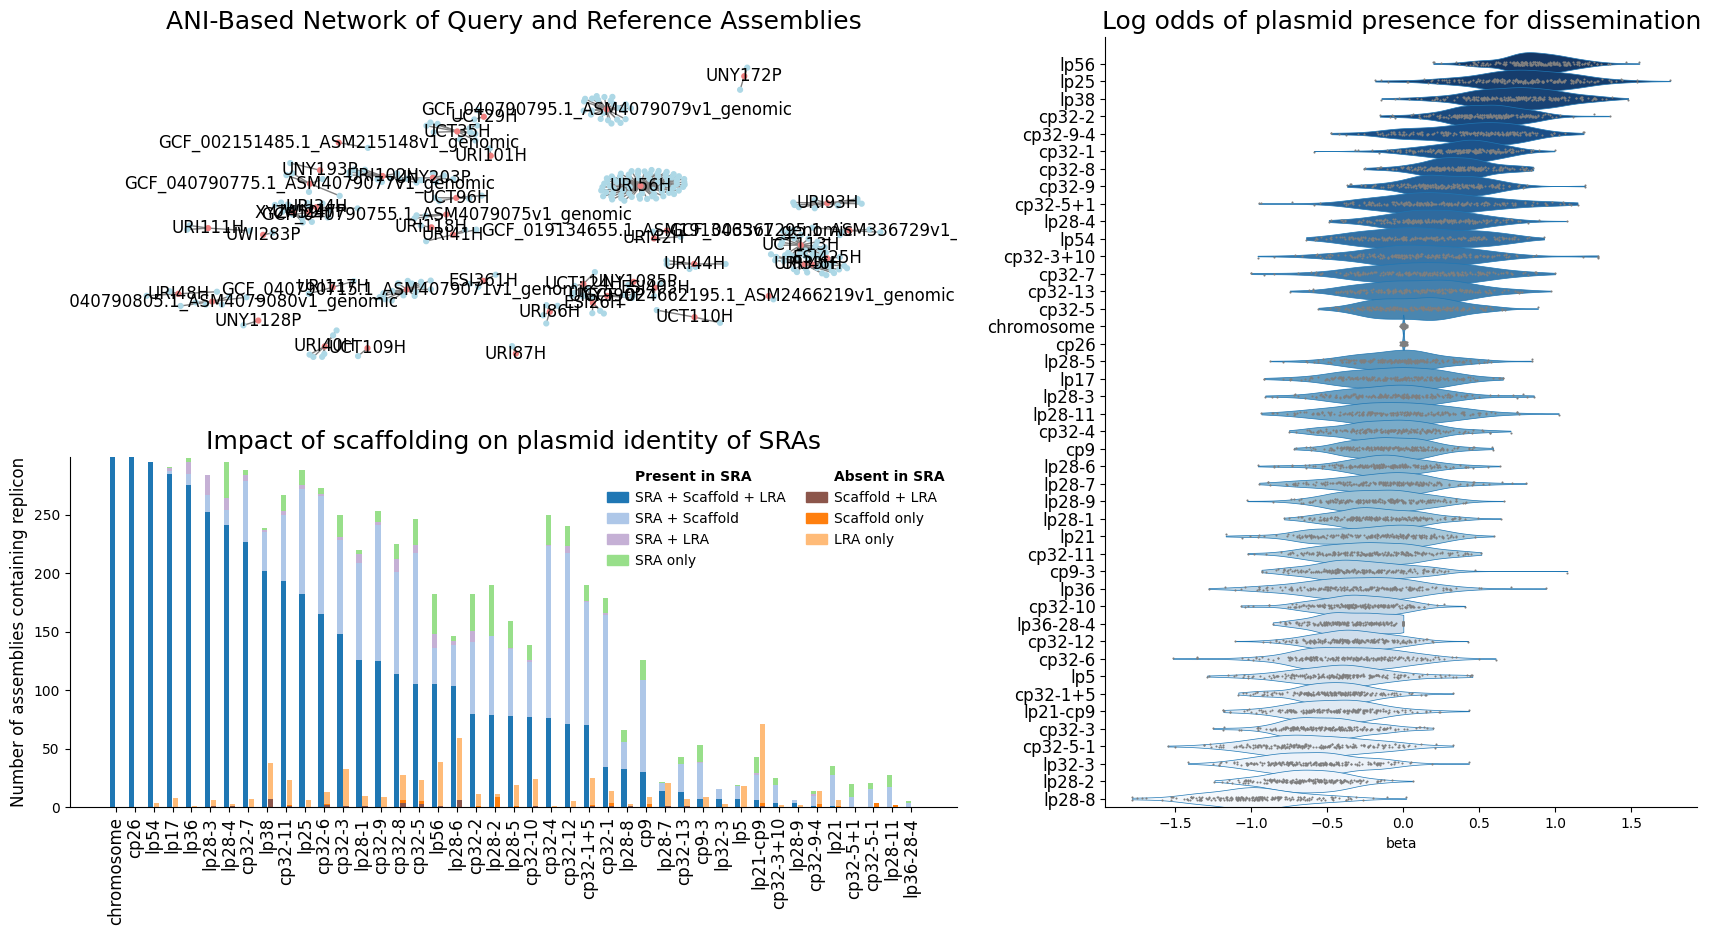

In [6]:
fig = plt.figure(figsize=(21, 10))
gs = gridspec.GridSpec(2, 2, figure=fig, width_ratios=[3, 2], height_ratios=[1, 1])

fs = 12

##############################################################################################################################################################
# PANEL A
##############################################################################################################################################################
ax = fig.add_subplot(gs[0, 0])
# Increase spacing with spring layout
pos = nx.spring_layout(G, seed=2, k=0.1)  # Increase k to spread nodes out
# Add small jitter *within* each connected component
def add_jitter(pos, scale=0.05, seed=42):
    np.random.seed(seed)
    new_pos = {}
    for component in nx.connected_components(G):
        jitter = (0.5 - np.random.rand()) * scale
        for node in component:
            x, y = pos[node]
            jitter_x = x + jitter
            jitter_y = y + jitter
            new_pos[node] = (jitter_x, jitter_y)
    return new_pos
pos_jittered = add_jitter(pos, scale=1, seed=1)
# Draw network
# Adjust node size scaling (decrease slightly)
node_sizes = [G.nodes[n]['size'] * 2 for n in G.nodes]  # Reduce scaling factor
node_colors = [G.nodes[n]['color'] for n in G.nodes]
node_sizes = [0.06*s for s in node_sizes]
nx.draw(G, pos_jittered, with_labels=False, node_size=node_sizes, node_color=node_colors, edge_color='gray', ax=ax)
# Draw labels only for coral-colored nodes
labels = {n: n for n in G.nodes if G.nodes[n]['color'] == 'lightcoral'}
nx.draw_networkx_labels(G, pos_jittered, labels=labels, font_size=fs, ax=ax)
ax.set_title("ANI-Based Network of Query and Reference Assemblies", fontsize=fs*1.5)

##############################################################################################################################################################
# PANEL B
##############################################################################################################################################################
ax = fig.add_subplot(gs[1, 0])
colors = [
    ['#1f77b4', '#aec7e8', '#c5b0d5', '#98df8a'],  # SRA-present
    ['#8c564b', '#ff7f0e', '#ffbb78']              # SRA-absent (brown and tan)
]

for replicon in all_reps['replicon']:
    plot_minibars(ax, replicon, colors, width=0.6)

draw_legend(ax, colors)

ax.set_xticks(range(len(all_reps)))
ax.set_xticklabels(all_reps['replicon'], rotation=90, fontsize=fs)
ax.set_ylabel("Count", fontsize=fs)
ax.spines[['top', 'right']].set_visible(False)

ax.set_title("Impact of scaffolding on plasmid identity of SRAs", fontsize=fs*1.5)
ax.set_ylabel('Number of assemblies containing replicon', fontsize=fs);

##############################################################################################################################################################
# PANEL C
##############################################################################################################################################################
ax = fig.add_subplot(gs[:, 1])
ax.set_title('Log odds of plasmid presence for dissemination', fontsize=fs*1.5);
sns.violinplot(y='plasmid',
               x='beta',
               hue='plasmid',
               data=beta_df.explode('beta'),
               inner=None,
               linecolor='tab:blue',
               palette='Blues_r',
               linewidth=0.5,
               # alpha=0.7,
               width=1.3,
               cut=0,
               ax=ax);
sns.stripplot(y='plasmid',
              x='beta',
              # hue='plasmid',
              data=beta_df.explode('beta'),
              jitter=True,
              color='tab:gray',
              alpha=1,
              # palette='Blues_r',
              s=1.5,
              ax=ax);
ylim = ax.get_ylim(); ax.set_ylim(ylim[0], ylim[1]-1)
yticks = ax.get_yticks(); ax.set_yticks(yticks);
yticklabels = ax.get_yticklabels(); ax.set_yticklabels(yticklabels, fontsize=fs);
ax.set_ylabel('');

ax.spines[['top', 'right']].set_visible(False);

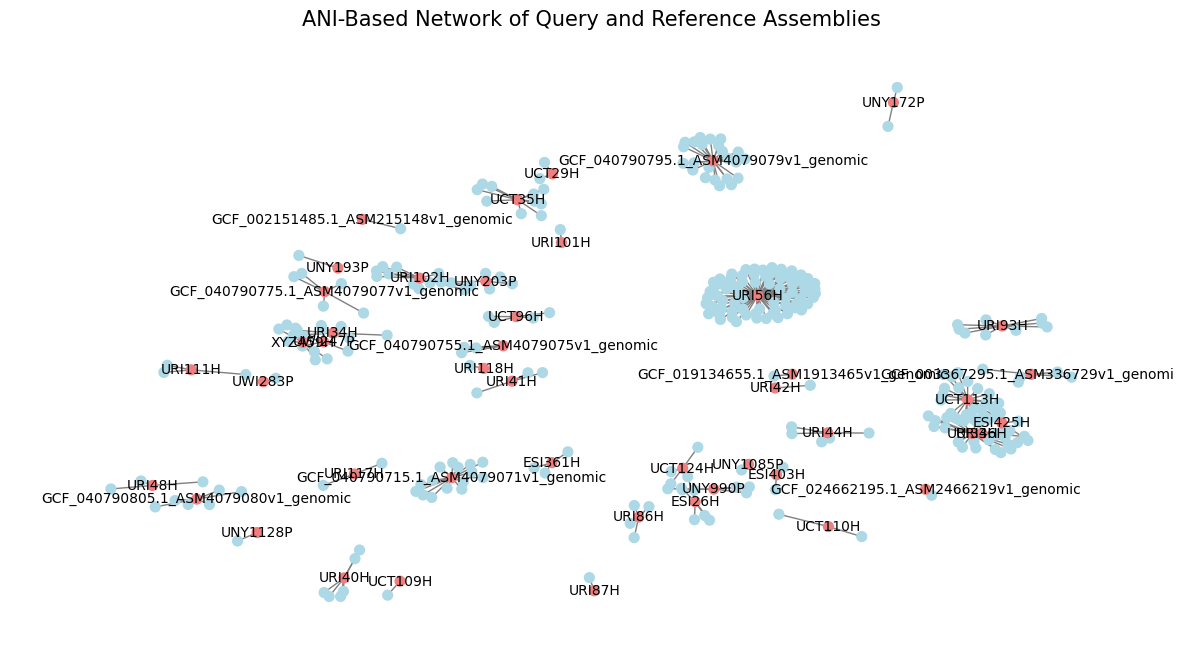

In [7]:
fs=10

fig, ax = plt.subplots(figsize=(15, 8))
# Increase spacing with spring layout
pos = nx.spring_layout(G, seed=2, k=0.1)  # Increase k to spread nodes out
# Add small jitter *within* each connected component
def add_jitter(pos, scale=0.05, seed=42):
    np.random.seed(seed)
    new_pos = {}
    for component in nx.connected_components(G):
        jitter = (0.5 - np.random.rand()) * scale
        for node in component:
            x, y = pos[node]
            jitter_x = x + jitter
            jitter_y = y + jitter
            new_pos[node] = (jitter_x, jitter_y)
    return new_pos
pos_jittered = add_jitter(pos, scale=1, seed=1)
# Draw network
# Adjust node size scaling (decrease slightly)
node_sizes = [G.nodes[n]['size'] * 2 for n in G.nodes]  # Reduce scaling factor
node_colors = [G.nodes[n]['color'] for n in G.nodes]
node_sizes = [0.25*s for s in node_sizes]
nx.draw(G, pos_jittered, with_labels=False, node_size=node_sizes, node_color=node_colors, edge_color='gray', ax=ax)
# Draw labels only for coral-colored nodes
labels = {n: n for n in G.nodes if G.nodes[n]['color'] == 'lightcoral'}
nx.draw_networkx_labels(G, pos_jittered, labels=labels, font_size=fs, ax=ax)
ax.set_title("ANI-Based Network of Query and Reference Assemblies", fontsize=fs*1.5);

fig.savefig('FIGURE_Scaffolding_A.png', bbox_inches='tight', dpi=200)

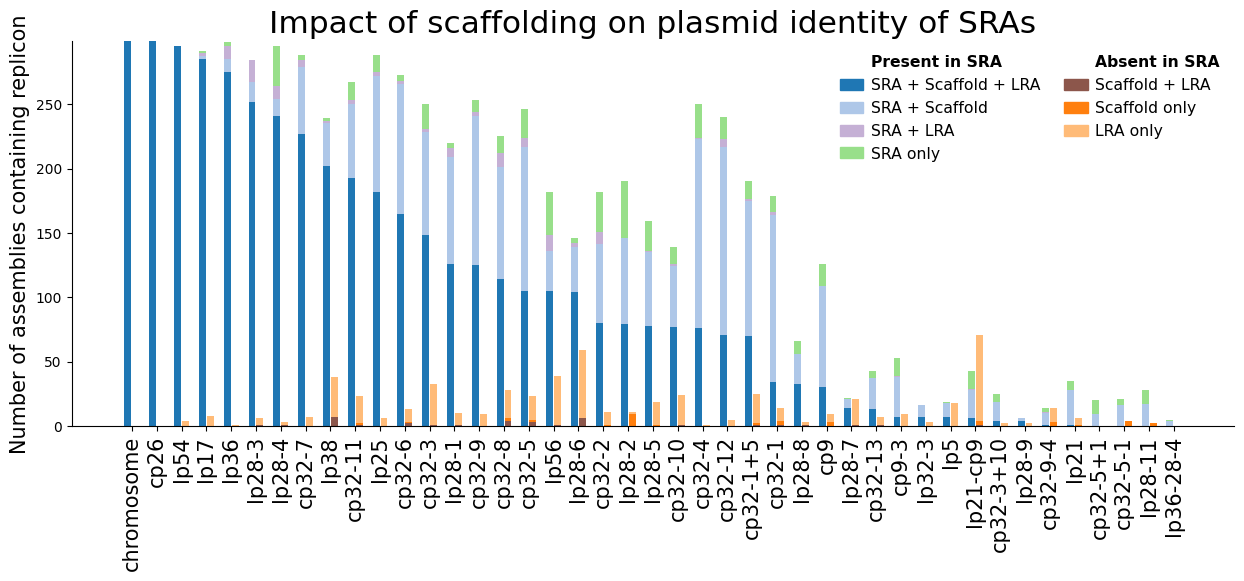

In [8]:
fs = 15

fig, ax = plt.subplots(figsize=(15, 5))
colors = [
    ['#1f77b4', '#aec7e8', '#c5b0d5', '#98df8a'],  # SRA-present
    ['#8c564b', '#ff7f0e', '#ffbb78']              # SRA-absent (brown and tan)
]

for replicon in all_reps['replicon']:
    plot_minibars(ax, replicon, colors, width=0.6)

draw_legend(ax, colors, fs=fs*0.75)

ax.set_xticks(range(len(all_reps)))
ax.set_xticklabels(all_reps['replicon'], rotation=90, fontsize=fs)
ax.set_ylabel("Count", fontsize=fs)
ax.spines[['top', 'right']].set_visible(False)

ax.set_title("Impact of scaffolding on plasmid identity of SRAs", fontsize=fs*1.5)
ax.set_ylabel('Number of assemblies containing replicon', fontsize=fs);

fig.savefig('FIGURE_Scaffolding_C.png', bbox_inches='tight', dpi=300)

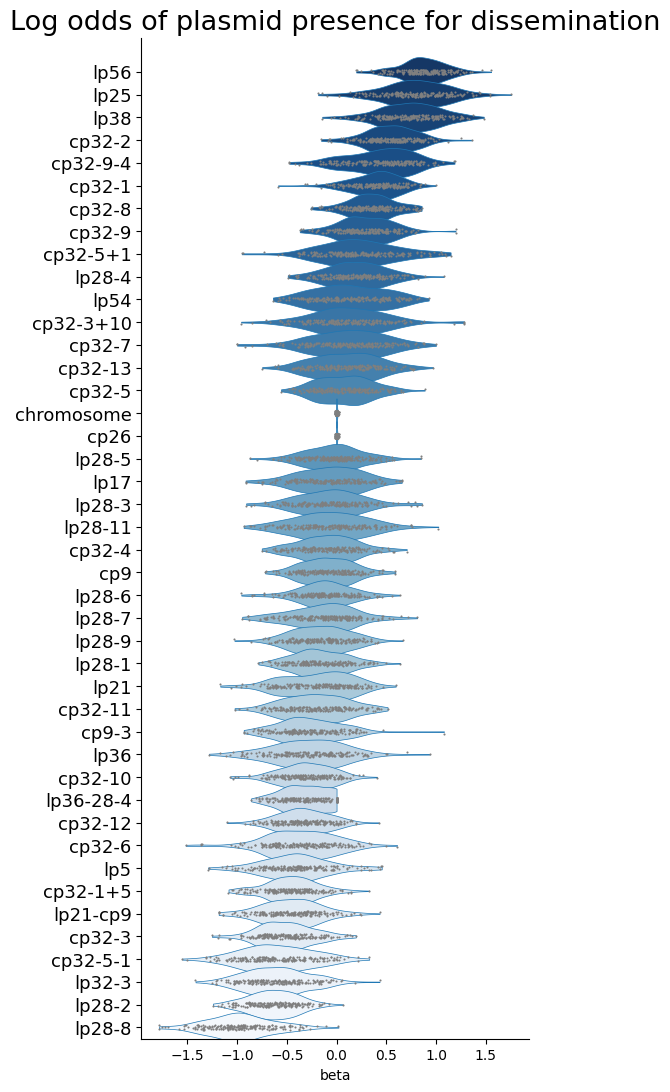

In [9]:
fs = 13

fig, ax = plt.subplots(figsize=(5, 13))
ax.set_title('Log odds of plasmid presence for dissemination', fontsize=fs*1.5);
sns.violinplot(y='plasmid',
               x='beta',
               hue='plasmid',
               data=beta_df.explode('beta'),
               inner=None,
               linecolor='tab:blue',
               palette='Blues_r',
               linewidth=0.5,
               # alpha=0.7,
               width=1.3,
               cut=0,
               ax=ax);
sns.stripplot(y='plasmid',
              x='beta',
              # hue='plasmid',
              data=beta_df.explode('beta'),
              jitter=True,
              color='tab:gray',
              alpha=1,
              # palette='Blues_r',
              s=1.5,
              ax=ax);
ylim = ax.get_ylim(); ax.set_ylim(ylim[0], ylim[1]-1)
yticks = ax.get_yticks(); ax.set_yticks(yticks);
yticklabels = ax.get_yticklabels(); ax.set_yticklabels(yticklabels, fontsize=fs);
ax.set_ylabel('');

ax.spines[['top', 'right']].set_visible(False);

fig.savefig('FIGURE_Scaffolding_D.png', bbox_inches='tight', dpi=300);